Pearson Correlation between Avg Daily Sentiment and Stock Return: 0.0207
P-value: 0.3305


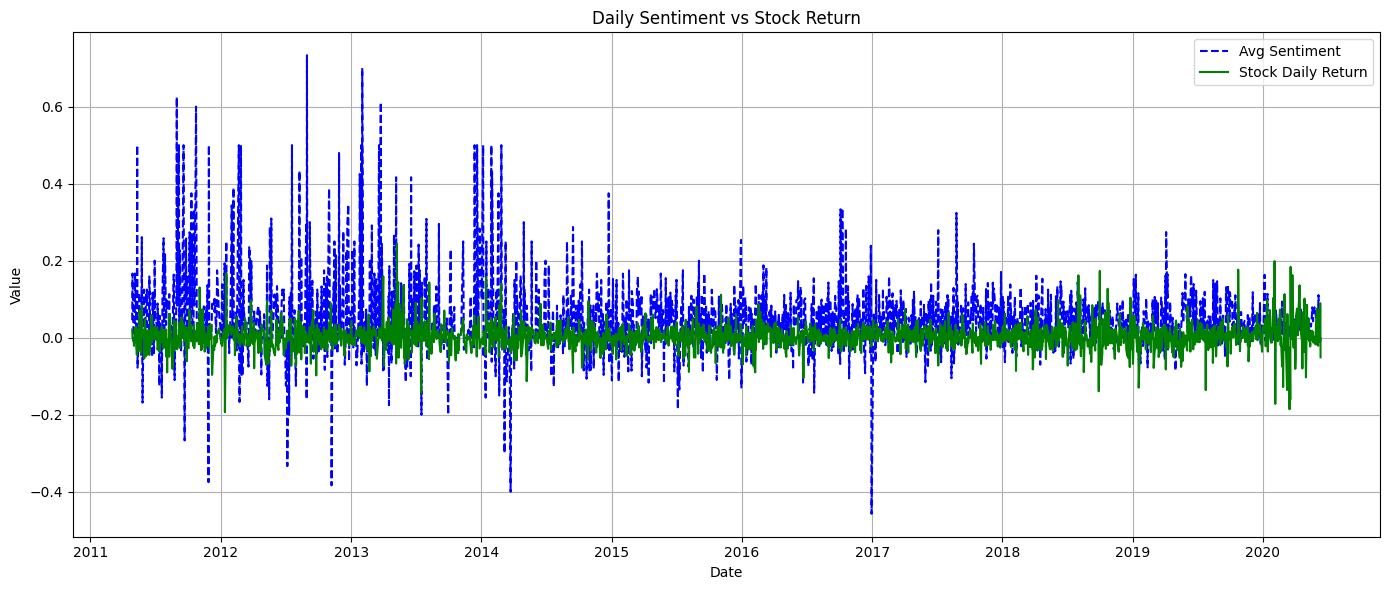

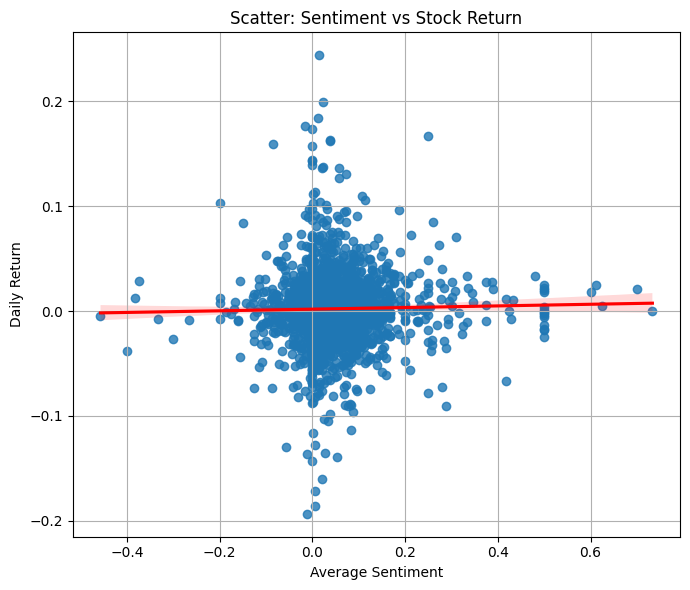

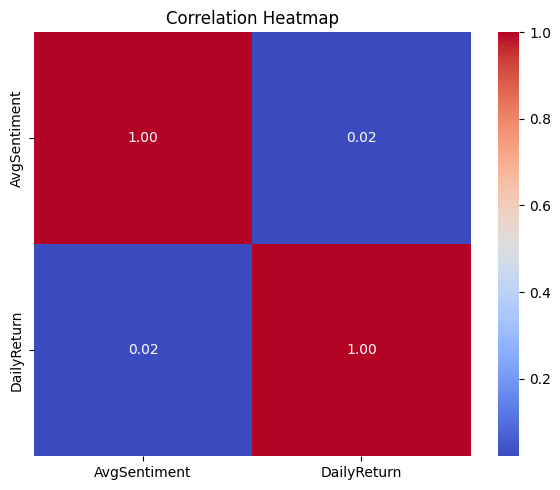

In [19]:
# notebooks/03_sentiment_correlation.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from scipy.stats import pearsonr

# Load news dataset
news_df = pd.read_csv("../data/raw_analyst_ratings.csv")
news_df['date'] = pd.to_datetime(news_df['date'], utc=True, errors='coerce')
news_df = news_df.dropna(subset=['date'])  # Remove rows where date parsing failed
news_df['date'] = news_df['date'].dt.date



# Sentiment scoring using TextBlob
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

news_df['sentiment'] = news_df['headline'].apply(get_sentiment)

# Aggregate sentiment scores per day
daily_sentiment = news_df.groupby('date')['sentiment'].mean().reset_index()
daily_sentiment.columns = ['Date', 'AvgSentiment']

# Load stock price data
stock_df = pd.read_csv("../data/TSLA_historical_data.csv", parse_dates=["Date"])
stock_df['Date'] = stock_df['Date'].dt.date  # Normalize timestamp to date only

# Calculate daily returns
stock_df['DailyReturn'] = stock_df['Close'].pct_change()

# Merge sentiment with stock data
merged_df = pd.merge(daily_sentiment, stock_df, on='Date', how='inner')

# Drop NaNs from DailyReturn (first row usually NaN)
merged_df.dropna(subset=['DailyReturn'], inplace=True)

# Correlation calculation
corr, pval = pearsonr(merged_df['AvgSentiment'], merged_df['DailyReturn'])

print(f"Pearson Correlation between Avg Daily Sentiment and Stock Return: {corr:.4f}")
print(f"P-value: {pval:.4f}")

# --- Visualizations ---

# Line plot: Avg Sentiment vs Daily Return
plt.figure(figsize=(14,6))
plt.plot(merged_df['Date'], merged_df['AvgSentiment'], label='Avg Sentiment', color='blue', linestyle='--')
plt.plot(merged_df['Date'], merged_df['DailyReturn'], label='Stock Daily Return', color='green')
plt.title('Daily Sentiment vs Stock Return')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

# Scatter plot with trend line
plt.figure(figsize=(7,6))
sns.regplot(x='AvgSentiment', y='DailyReturn', data=merged_df, line_kws={"color": "red"})
plt.title('Scatter: Sentiment vs Stock Return')
plt.xlabel('Average Sentiment')
plt.ylabel('Daily Return')
plt.grid(True)
plt.tight_layout()
plt.show()

# Heatmap of correlation matrix
corr_matrix = merged_df[['AvgSentiment', 'DailyReturn']].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()
